# Python for (open) Neuroscience

_Lecture 3.3_ - Running experiments

Luigi Petrucco

Jean-Charles Mariani

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vigji/python-cimec/blob/main/lectures/Lecture3.3_Run-experiments.ipynb)

## Outline

 - The basics:
     - live applications
     - timing
     - APIs
 - Interacting with hardware:
     - cameras
     - Arduino
 - Generating stimuli and experimental sequences:
     - `psychopy`

## The basics: live applications

When we are analysing data, we have a script that just runs once (ideally, as fast as possible).

For both acquiring data and control stimuli, we need a live application: something that keeps running until we shut it down or the experiment is finished

### The event loop

To keep the program running, often we define an <span style="color:indianred">event loop</span>! Something that might look like:

In [10]:
while True:  # a minimal event loop that keeps a program online
    pass

KeyboardInterrupt: 

### `time` in Python

To control more precisely what happens in event loops we need tools to check timing of the application.

The `time` module (from the standard library) offers such tools!

In [4]:
import time
time.time()  # returns a float, seconds since January 1, 1970, 00:00:00 ("Unix epoch")

1687357057.231839

In [11]:
TOTAL_TIME = 3

print("Program starts")
start_time = time.time()  
while time.time() - start_time < TOTAL_TIME:
    pass

print("Program ends")

Program starts
Program ends


Now we control time, but there's an undefined amount of iterations in our program:

In [12]:
TOTAL_TIME = 1
N_REPS_TEST = 5

for _ in range(N_REPS_TEST):
    counter = 0
    start_time = time.time() 
    
    while time.time() - start_time < TOTAL_TIME:
        counter += 1

    print(f"Program ends, after {counter} iterations (avg. {TOTAL_TIME*10**9/(counter+1)} ns/iteration)")

Program ends, after 8250226 iterations (avg. 121.20878613400576 ns/iteration)
Program ends, after 8925430 iterations (avg. 112.03940739668482 ns/iteration)
Program ends, after 8921309 iterations (avg. 112.09116149982458 ns/iteration)
Program ends, after 8705861 iterations (avg. 114.86513340091997 ns/iteration)
Program ends, after 8990586 iterations (avg. 111.22744265752614 ns/iteration)


The execution speed can fluctuate a lot. It depends on both the Python code we write and the availability of cpu resources!

We can control more precisely the loop event timing using `sleep` to pause the program in a controlled fashon:

In [14]:
PAUSE_S = 0.001

for _ in range(N_REPS_TEST):
    counter = 0
    start_time = time.time() 
    
    while time.time() - start_time < TOTAL_TIME:
        time.sleep(PAUSE_S)
        counter += 1

    print(f"Program ends, after {counter} iterations \
            (avg. {TOTAL_TIME*10**3/(counter+1)} ms/iteration)")

Program ends, after 791 iterations             (avg. 1.2626262626262625 ms/iteration)
Program ends, after 789 iterations             (avg. 1.2658227848101267 ms/iteration)
Program ends, after 787 iterations             (avg. 1.2690355329949239 ms/iteration)
Program ends, after 789 iterations             (avg. 1.2658227848101267 ms/iteration)
Program ends, after 788 iterations             (avg. 1.267427122940431 ms/iteration)


Small time intervals with `sleep` are not crazy good! 
 - OS dependent - should always be tested
 - reliable down to tens of ms, below more fluctuations expected
 - If you need sub-ms accuracy in your application maybe Python is not the way to go!

There are some hardcore tricks that can be used to control more tightly access to the cpu, resulting in better timing. 

E.g., `psychopy` `wait()` function implements them!

In [15]:
from psychopy.core import wait, getTime

PAUSE_S = 0.001

for _ in range(N_REPS_TEST):
    counter = 0
    start_time = getTime()
    while getTime() - start_time < TOTAL_TIME:
        wait(PAUSE_S)
        counter += 1

    print(f"Program ends, after {counter} iterations (avg. {TOTAL_TIME*10**3/(counter+1)} ms/iteration)")

Program ends, after 990 iterations (avg. 1.0090817356205852 ms/iteration)
Program ends, after 989 iterations (avg. 1.0101010101010102 ms/iteration)
Program ends, after 988 iterations (avg. 1.0111223458038423 ms/iteration)
Program ends, after 989 iterations (avg. 1.0101010101010102 ms/iteration)
Program ends, after 990 iterations (avg. 1.0090817356205852 ms/iteration)


## Measure time

We can also use `time()` to measure elapsed time (e.g., a reaction time):

In [16]:
time.sleep(1)  # pause 1 second before starting the task
start = time.time()
_ = input("Press enter!")  # a new function to pass inputs to a script! 
end = time.time()
print(f"Reaction time: {end - start} s") 

Press enter! 
Reaction time: 1.3266379833221436 s


### The single thread issue

Note that in Python we give instructions one by one to the interpreter. This can be a problem for handling multiple event streams!

Imagine you are showing a stimulus changing constantly and you want to acquire an input from the user. You want to simultaneously run the code lines that wait for the user input, and the code lines that wait for the input.

In general, you have two options:

 1. Handle the concurrency with timeouts

 2. Start using multi-threading (to have different tasks running in parallel)

### Timeouts

In [ ]:
# Pseudocode for concurrency with timeouts:

while timer() < experiment_duration:
    user_input = read_input(timeout=0.005)
    update_stimulus()

Stimuli on a screen are usually refreshed every approx. 16 ms, so there's plenty of time to do other things between frames!

### Multi-threading

In [ ]:
# Pseudocode for multi-threading - in reality is more painful!
class UserReader: # Class to read user input
    pass

class StimulusUpdater: # Class to update stimulus
    pass
    
reader, updater = UserReader(), StimulusUpdater()

reader.start()
updater.start()
...
reader.stop()
updater.stop()

## APIs

Many pieces of hardware come with their Python <span style="color:indianred">Application Programming Interface (API)</span>.

The API of a piece of harwardare is a package that we `pip install` and we can use to control the hardware.

Usually object-oriented! The hardware object is represented very neatly with a virtual object.

## Acquiring data

### Cameras (and their APIs)

Cameras APIs give us classes and methods to:
- Initialize Camera objects
- grab frames from cameras
- change camera parameters
- shut down cameras

Let's have a look at a very common one: `opencv`

In [17]:
# pip install python-opencv to use cv2:
import cv2
from matplotlib import pyplot as plt
 
# Instantiate a video capture object (camera):
vid = cv2.VideoCapture(0)

In [18]:
type(vid)

cv2.VideoCapture

To grab frames, `.read()` method

In [20]:
_, frame = vid.read()  # read method to capture frame

In [23]:
frame.shape

(1080, 1920, 3)

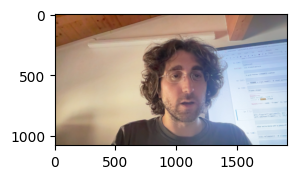

In [25]:
plt.figure(figsize=(3, 3))
plt.imshow(frame[:, :, [2,1,0]])  # Frame is BGR instead of RGB, swap colors to plot

After we're done with a piece of hardware, it is always good to shut it off:

In [26]:
vid.release()  # close the camera reader and free to camera

Cameras from any vendor offer APIs, and a great majority have Python APIs!

(Practical 3.3.0)

## Something on electronics

We read data and control hardware mostly using:
 - digital signals
 - analog signals

### Analog signals

A continuous voltage in a range (usually 0-5 V or 0-10 V) maps some continuous variable.

Analog signals are acquired and generated by specialized hardware - your computer can't talk analog with any kind of device!

That's part of the reason why we use Arduinos, NI boards, digitizers, etc.

Many recording devices produce analog signals (e.g., microphones), but then such signals have to be digitized. This requires chunking in time and approximation in the resolution.

### Digital signals

Discrete signals - ON or OFF (usually 0/3.3 V or 0/5 V, depending on the device)

Much more robust to noise! Those are the signals that digital devices such as the computer use

As fast as analog signals, but with very small bandwidth (two states, ON/OFF)

### Serial communication

Digital signals can be used to transmit bits of information through time!

- This requires the sender and the receiver to agree on a clock (baud rate)
- Reasonable bandwidth and resistent to noise


![Arduino](./files/serialcomm.png)


All devices we connect to the computer are <span style="color:indianred">serial devices</span> (USB: Universal Serial Bus)

### Communication with serial devices

The python `Serial` library gives us a way to speak with digital devices

In [ ]:
import serial

port = serial.Serial('COM3', baudrate=9600) # Configure the serial port creating an object

# Send data to the device:
command = b'dosomething\n'
port.write(command)

# Read response from the device:
response = port.readline()

port.close()  # Always shut down communication with a device

# Arduino

- Open-source microcontroller
- Digital/analogic input and output channels
- We can use it just as an interface to deal with those signals...
- ...or as a controller if we need very precise timing

![Arduino](./files/arduino.png)

### Interfacing hardware

Arduino is a great interface for hardware...

...reading sensors of any kind:
- light (eg photodiode)
- temperature
- pressure
- conductance
- ...

...and controlling hardware:
- LEDs
- motors / actuators
- valves
- resistances 
- buzzers (sounds)
- ...

### Arduino code

The arduino processor is constantly executing some C code that we load on the board. 

Arduino has its own event loop!

In [ ]:
###>> The code here is C/Arduino code, not Python!
void setup() {
  pinMode(13, INPUT);               // configure pin 13 to be an input
  Serial.begin(9600);               // configure baud rate to match the computer's
}

void loop() {                       // The code inside here runs continuously
  int value = analogRead(pin);      // read the state of the port (0/1)
  Serial.println(value);            // print value on the serial port
  delay(100);                       // wait 100 ms
}
###>>

## Firmata library

If we do not care about controlling things from the Arduino, we can load on the Arduino some default code called Firmata. In this way, we can directly write and read the Arduino pins from Python with the `pyfirmata` library:

In [ ]:
from pyfirmata import Arduino, util

board = Arduino('COM3')  # create the board object

# Configure the pin:
pin = board.get_pin('d:2:i')  # a pin object representing the second pin in input mode

# Read and print the pin state
print("Pin state:", pin.read())

board.exit()  # Close the connection

### Other boards

There are many other boards we can use for handling digital and analog signals, eg:
- National Instruments boards
- Labjack boards

They come with higher prices and higher performances compared to Arduino!

- Raspberry py

Basically a minicomputer - runs Python!

## Controlling stimuli

Many times we need to control stimuli to present to the experimental subject:

- visual
- auditory
- mechanical
- ...

### The `psychopy` library

(not a super expert...)

For many kind of stimuli, exp. visual and auditory, we can use the `psychopy` library!

(It also comes with a GUI - we won't be covering the GUI here though! It is quite ugly...)

In `psychopy` there's many modules!
 - any sort of visual stimulus
 - sound card control for sound stimuli
 - timers and clocks
 - logs, for data saving
 - inputs from mouse and keyboard
 - input from cameras
 - input from external hardware (EEG, eye tracking...)
 - ...

### Running `psychopy` scripts

`psychopy` experiments are encoded in scripts that import code from the `psychopy` library.

Note that the `psychopy` GUI generates .py scripts and runs its own Python (yes, yet another Python on your computer...)

(Showcase `psychopy` scripts)

## Data saving

Keep track of as many data as possible using code!
- You can enforce the required inputs
- You're guaranteed consistent formatting

The less you require to be added manually by the experimenter, the better! (e.g., never ask for date/hour...)

### Formats

`.json` files are light, compatible, textual files for (hierarchical) metadata dictionaries

`.csv` files can be great for tabular data that can be accomodated in a `pandas` dataframe!

For large data (e.g., frames or data with high sampling freq.), numpy binary files `.npy` using the `np.save(data_ndarray)` function.

## Wrapup: running experiments in Python

**Pros**

- Jack-of-all-trades: we need to remember only one language for experiments, preprocessing, stats, etc.
- We can save and load data with the same libraries
- Thousands of available libraries
- Thousands of available APIs

**Cons**

- Execution time becomes unreliable at the ms/sub-ms scale (unless we use specialized hardware)
- Concurrency issues

(Practical 3.3.1)